In [1]:
%cd "~/code/snet/moses-incons-pen-xp"
%load_ext autoreload
%autoreload

/home/xabush/code/snet/moses-incons-pen-xp


In [2]:
import numpy as np
import jax
import jax.random as rng
import jax.numpy as jnp
import numpyro as npyro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
import arviz as az
import scipy
import scipy.stats as st
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from notebooks.variable_selection.MosesEstimator import *
from scripts.samplers import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
### Python version of Jonathan's code to generate synth network
def gen_synth_net(num_feats, p=0.3):
    J = np.zeros((num_feats, num_feats))
    for i in range(num_feats):
        for j in range(i+1, num_feats):
            u = np.random.uniform()
            if u < p:
                r = st.halfnorm().rvs()
                # r = 1
                J[i, j] = r
                J[j, i] = r

    return J

def samples_to_feats(samples):
    feats = []
    for i in range(samples.shape[0]):
        feat_idx = list(np.nonzero(samples[i])[0])
        if len(feat_idx) == 0 or feat_idx in feats: continue
        feats.append(feat_idx)
    return feats

def rank_by_mi(samples, J, X, Y, eta=1.0, B=1.0):
    samples_c = samples.reshape((samples.shape[0]*samples.shape[1], samples.shape[2]))
    samples_unq = np.unique(samples_c, axis=0)
    energy_vals = [bmm_energy(samples_unq[i], J, eta=eta) for i in range(samples_unq.shape[0])]
    feats = samples_to_feats(samples_unq)
    mi_scores = []
    for eng, feat in zip(energy_vals, feats):
        s_score = 0.0
        for f in feat:
            mi = mutual_info_score(Y, X[:,f])
            s_score += mi

        mi_scores.append(s_score - B*eng)

    idxs = np.argsort(np.array(mi_scores))[::-1]
    feats = list(np.array(feats)[idxs])

    return feats, np.sort(np.array(mi_scores))[::-1]

def rank_by_cond_prob(samples, J, X_train, y_train, energy_fn, eta=1.0):
    samples_c = samples.reshape((samples.shape[0]*samples.shape[1], samples.shape[2]))
    samples_unq = np.unique(samples_c, axis=0)
    prob_vals = [np.exp(-energy_fn(samples_unq[i], J, X=X_train, Y=y_train, eta=eta)) for i in range(samples_unq.shape[0])]
    idx = np.argsort(np.array(prob_vals))[::-1]
    samples_unq = samples_unq[idx]
    feats = samples_to_feats(samples_unq)
    return feats

def get_rand_feats(p, n=100):
    feats = []
    for i in range(n):
        idx = np.random.randint(0, 2, size=p)
        feats.append(list(np.nonzero(idx)[0]))

    return feats

def plot_energy_model(J, net_energy, net_spins, samples, energy_fn, X=None, Y=None, eta=1.0):
    chains, num_samples, n_dim = samples.shape
    samples = samples.reshape((chains*num_samples, n_dim))
    energy_vals = [energy_fn(samples[i], J, X, Y, eta=eta) for i in range(samples.shape[0])]
    prob_vals = [np.exp(-e) for e in energy_vals]
    fig, ax = plt.subplots(2, 2, figsize=(24, 18))
    s = np.arange(1, net_energy.shape[1] + 1)
    t = np.arange(1, samples.shape[0] + 1)
    for i in range(net_energy.shape[0]):
        ax[0, 0].plot(s, net_energy[i])
        ax[1, 0].plot(s, net_spins[i])

    ax[0, 1].plot(t, energy_vals)
    ax[1, 1].plot(t, prob_vals)

    ax[0, 0].set(title="Net Energy over Time", xlabel="Time", ylabel="$E(\gamma)$")
    ax[1, 0].set(title="Net spins over Time", xlabel="Time", ylabel="Sping")
    ax[0, 1].set(title="Energy for 10000 samples", xlabel="i", ylabel="$E(\gamma)$")
    ax[1, 1].set(title="Probability for 10000 samples", xlabel="i", ylabel="$p(\gamma)$")

    return energy_vals, prob_vals

def logistic(x):
    return 1/(1 + jnp.exp(-x))

def jax_prng_key():
    return jax.random.PRNGKey(np.random.randint(int(1e5)))

def hamm(a,b):
    return len(np.nonzero(a != b)[0])


def generate_potential_energy_fn(X, y, J, sigma, mu):
    X = jax.device_put(X)
    y = jax.device_put(y)
    J = jax.device_put(J)
    mu = jax.device_put(mu)
    # sigma = jax.device_put(sigma)
    beta_dist = distrax.MultivariateNormalFullCovariance(sigma)
    def potential_energy(gamma, beta):
        gamma_f = gamma.astype(jnp.float32)
        # beta_prior_potential = jnp.sum(
        #     0.5 * jnp.log(2 * jnp.pi * sigma ** 2) + 0.5 * beta ** 2 / sigma ** 2
        # )
        beta_prior_potential = beta_dist.log_prob(beta)
        probs = 1 / (
                1 + jnp.exp(-jnp.dot(jnp.dot(X, jnp.diag(gamma_f)), beta))
        )
        likelihood_potential = -jnp.sum(
            y * jnp.log(probs + 1e-12) + (1 - y) * jnp.log(1 - probs + 1e-12)
        )

        gamma_potential = -0.5*jnp.dot(jnp.dot(gamma_f.T, J), gamma_f) + mu*jnp.sum(gamma_f)

        return beta_prior_potential + likelihood_potential + gamma_potential

    return potential_energy

def is_related_to_causal(J, causal_feats):
    s = J.shape[0]
    r = np.zeros(s, dtype=np.int)
    for i in range(s):
        for f in causal_feats:
            if i == f or J[i, f] != 0: r[i] = 1

    return r

In [4]:
from notebooks.variable_selection.util import load_bmm_files
seeds, data_dfs, net_dfs, feats = load_bmm_files("data/bmm_data_thr_2_new/")
print(f"seeds - {seeds}")
seed_idx = 2
np.random.seed(seeds[seed_idx])
J = net_dfs[seed_idx].to_numpy()
J_pos = np.abs(net_dfs[seed_idx].to_numpy())
J_pos[J_pos > 0.0] = 1.0
L = scipy.sparse.csgraph.laplacian(J_pos, normed=True)
# L = torch.from_numpy(L)
df = data_dfs[seed_idx]
X, y = df[df.columns.difference(["y"])].to_numpy().astype(np.float_), df["y"].to_numpy().astype(np.float_)
p = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seeds[seed_idx], shuffle=True, stratify=y)
key = rng.PRNGKey(seed_idx)
base_auc = []
with open("data/bmm_data_thr_2_new/base_auc.txt", "r") as fp:
    base_auc = [float(i) for i in fp.readline().strip().split(',')]

X_train_ord, X_test_ord, y_train_ord, y_test_ord = X[:800], X[800:1000], y[:800], y[800:1000]
# X_test, y_test = X_test.to_numpy(), y_test.to_numpy()
print(f"causal feats for seed - {seeds[seed_idx]} - {np.array(feats[seed_idx]) - 1} , base auc - {base_auc[seed_idx]:.2f}")

seeds - [82, 91, 13, 92, 64, 10, 28, 55, 96, 97]
causal feats for seed - 13 - [75 65 51 89 17] , base auc - 0.69


In [5]:
from numpyro.infer import MCMC, MixedHMC, HMC
import numpyro.distributions as dist

def gamma_energy(gamma, J, eta, mu):
    return 0.5*eta*jnp.dot(jnp.dot(gamma.T, J), gamma) - mu*jnp.sum(gamma)

def model(X, y, sigma, J, eta=1.0, mu=1.0):
    L = np.linalg.cholesky(sigma)
    z = npyro.sample('z', dist.Normal(np.zeros(p), 1))
    beta = npyro.deterministic('beta', L @ z)
    # beta = npyro.sample('beta', dist.MultivariateNormal(0, sigma))
    gamma = npyro.sample('gamma', dist.Bernoulli(np.full(X.shape[1], 0.5)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    prob = npyro.deterministic("prob", jnp.dot(X, (beta * gamma)))
    # print(f"Probs: {prob.shape}")
    likelihood = npyro.sample("y", dist.Bernoulli(logits=prob),
                              obs=y)

# sigma = 0.3 * np.ones((p, p))
# np.fill_diagonal(sigma, 25)
#
kernel = MixedHMC(HMC(model), random_walk=False)
mcmc = MCMC(kernel, num_warmup=300, num_samples=1000, num_chains=3, progress_bar=True)
mcmc.run(key, X_train, y_train, 25*np.identity(p), J, 1.0, 1.0)

sample: 100%|████████████████████████████████████████████████| 1300/1300 [04:51<00:00,  4.46it/s, 1241 steps of size 5.28e-03. acc. prob=0.96]


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

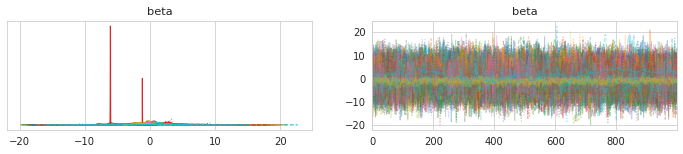

In [7]:
import arviz as az
infr_data = az.from_numpyro(mcmc)
az.plot_trace(infr_data, var_names=["beta"])

In [8]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[1]      0.00      0.06      0.00      0.00      0.00       nan      1.01
  gamma[2]      0.98      0.15      1.00      1.00      1.00    843.72      1.00
  gamma[3]      0.01      0.09      0.00      0.00      0.00       nan      1.03
  gamma[4]      0.76      0.43      1.00      0.00      1.00     23.84      1.17
  gamma[5]      0.86      0.35      1.00      0.00      1.00    213.83      1.02
  gamma[6]      0.29      0.45      0.00      0.00      1.00     73.25      1.02
  gamma[7]      0.52      0.50      1.00      0.00      1.00     14.64      1.17
  gamma[8]      0.01      0.12      0.00      0.00      0.00    970.60      1.00
  gamma[9]      1.00      0.00      1.00      1.00      1.00       nan       nan
 gamma[10]      0.97      0.18      1.00      1.00      1.00       nan      1.02
 gamma[11]      0.99      0

In [9]:
gamma_samples = jax.device_get(mcmc.get_samples()["gamma"])
beta_samples = jax.device_get(mcmc.get_samples()["beta"])

In [40]:
jnp.save("data/gamma_samples_nb_13b.npy",gamma_samples)
jnp.save("data/beta_samples_nb_13b.npy", beta_samples)

In [10]:
np.mean(beta_samples, axis=0)

array([ 1.6024678e+00,  1.0586623e+00,  6.4083970e-01,  1.6137985e+00,
        2.9659534e+00, -1.0577304e+00, -4.7273022e-01,  7.3477262e-01,
        6.6257611e-02, -2.8850756e+00,  1.8574958e+00,  2.6701696e+00,
        8.9307398e-01,  1.8047050e-01, -4.8852296e+00, -1.7713478e-01,
        2.4986811e+00,  2.4136858e+00,  3.7865628e-02,  2.8889400e-01,
        1.9979652e+00, -9.4800985e-01, -2.2781770e+00, -9.9699706e-01,
        2.0528696e+00, -1.2464403e+00, -1.0071243e+00,  8.3190137e-01,
       -2.9893371e-01, -2.5057633e+00,  9.0668744e-01, -4.1279104e-01,
       -1.3551517e-01, -5.1973110e-01, -2.5971216e-01,  9.9021292e-01,
        5.8155310e-01, -3.2335362e+00, -1.2694904e+00, -5.3233737e-01,
        1.5924299e+00, -2.1109221e+00,  5.2065313e-02, -8.3612120e-01,
        1.6508427e+00, -7.0893931e-01, -3.6055177e-02, -6.0221201e-01,
       -1.8716240e-01, -3.3562325e-02,  1.3023347e+00,  2.9926026e-01,
       -1.4258937e+00,  3.6417452e-01,  7.9425979e-01, -3.2085478e+00,
      

In [112]:
feats_hmc_rand = rank_hmc_feats_rand(gamma_samples_2)
print(average_length(feats_hmc_rand))

44.76767676767677


In [ ]:
res_auc_mhmc_rand = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], feats_hmc_rand[:100])
res_auc_mhmc_rand.describe()

 28%|██████████                          | 27/97 [22:47<3:14:51, 167.02s/it, m_tr=0.61, m_te=0.63, l_tr=0.50, l_te=0.50]

In [87]:
res_auc_mhmc_rand.describe()

,moses_cv_score,moses_test_score,log_cv_score,log_test_score
count,97.000000,97.000000,97.000000,97.000000
mean,0.625873,0.597876,0.505442,0.522861
std,0.016822,0.039700,0.004641,0.014733
min,0.591381,0.522588,0.495494,0.495516
25%,0.614287,0.566932,0.502496,0.514034
50%,0.624791,0.595001,0.504746,0.532553
75%,0.638574,0.625311,0.508379,0.534795
max,0.664352,0.696562,0.515375,0.569590


#### Variance based selection

In [80]:
gamma_samples_2 = jax.device_get(mcmc_2.get_samples()["gamma"])
beta_samples_2 = jax.device_get(mcmc_2.get_samples()["beta"])

In [13]:
%autoreload
from notebooks.variable_selection.util import parse_mcmc_var_results
seeds_var = [82, 91, 13,]
var_results_df = parse_mcmc_var_results(seeds_var, "data/mcmc_variable_selection_var/", 31)

In [12]:
np.argsort(np.abs(np.mean(beta_samples, axis=0)))[::-1]

array([14, 37, 55,  4,  9, 11, 63, 29, 16, 17, 22, 92, 58, 41, 24, 20, 91,
       56, 90, 10, 84, 44,  3,  0, 40, 68, 69, 81, 70, 52, 59, 89, 50, 38,
       25, 74, 93, 98,  1,  5, 88, 26, 23, 35, 21, 30, 80, 12, 43, 27, 54,
        7, 45,  2, 67, 47, 76, 36, 75, 60, 99, 66, 39, 33, 83,  6, 77, 79,
       31, 71, 82, 53, 73, 97, 51, 28, 61, 86, 19, 64, 34, 62, 96, 48, 13,
       15, 85, 32, 94, 87, 95,  8, 42, 65, 18, 46, 78, 49, 57, 72])

In [85]:
## re-add seed 10 results
seed_10_cv_scores, seed_10_test_scores = [], []
feats_var_seed_10 = []
vars = np.linspace(0.5, 10, 10)
for i in range(vars.shape[0]):
    var = vars[i]
    idx = np.var(beta_samples_2, axis=0) < var
    ar = np.arange(100)
    feats_idx = ar[idx]
    print(f"Feats with var thr {var} - {feats_idx}")

    res_hmc_auc = run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], [feats_idx])
    seed_10_cv_scores.append(res_hmc_auc["moses_cv_score"])
    seed_10_test_scores.append(res_hmc_auc["moses_test_score"])
    feats_var_seed_10.append(feats_idx)

  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 0.5 - [30 42 45]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 1.5555555555555556 - [ 5 30 34 42 45 50 51]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 2.611111111111111 - [ 5 30 34 42 45 50 51 82 97]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 3.666666666666667 - [ 5 26 30 34 42 45 50 51 82 86 97]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 4.722222222222222 - [ 5 14 26 30 34 42 45 50 51 52 82 86 97]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 5.777777777777778 - [ 0  5 12 14 26 30 34 42 45 50 51 52 82 86 94 96 97]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 6.833333333333334 - [ 0  5 12 14 26 30 33 34 40 42 43 45 50 51 52 71 82 86 94 96 97]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 7.888888888888889 - [ 0  5 12 14 26 30 33 34 39 40 42 43 45 50 51 52 55 71 82 86 94 96 97 98]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 8.944444444444445 - [ 0  5 12 14 26 30 32 33 34 39 40 42 43 45 50 51 52 55 71 82 86 94 96 97
 98]


  0%|                                                                                                 | 0/1 [00:00<?, ?it/s]

Feats with var thr 10.0 - [ 0  5 12 14 26 30 32 33 34 39 40 42 43 45 50 51 52 55 71 73 74 82 86 94
 96 97 98]


100%|█████████████████████████████████████████████| 1/1 [00:34<00:00, 34.28s/it, m_tr=0.60, m_te=0.65, l_tr=0.50, l_te=0.52]


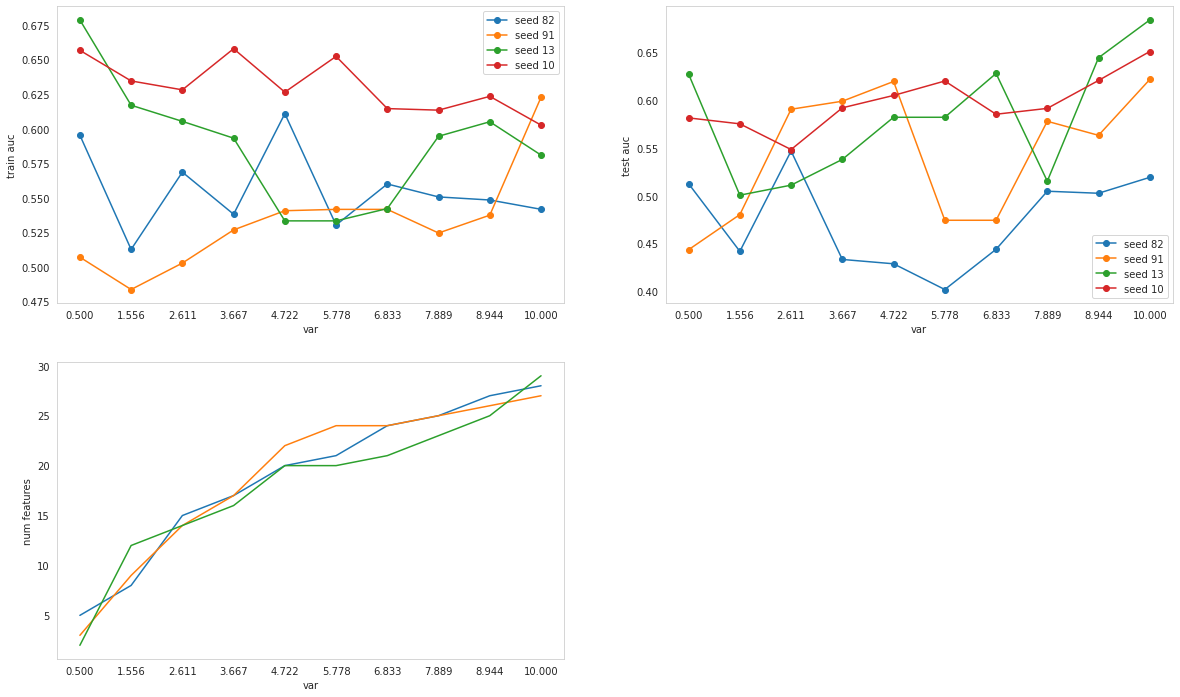

In [110]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
for i, seed in enumerate(seeds_var):
    ax[0, 0].plot(vars, var_results_df[i]["moses_cv_score"], label=f"seed {seed}", marker='o')
    feats_i = []
    for j in range(var_results_df[i].shape[0]):
        feats_i.append(len(var_results_df[i].iloc[j]["feats"].split(",")))
    ax[1, 0].plot(vars, feats_i)

for i, seed in enumerate(seeds_var):
    ax[0, 1].plot(vars, var_results_df[i]["moses_test_score"], label=f"seed {seed}", marker='o')

ax[0, 0].plot(vars, seed_10_cv_scores, label="seed 10", marker='o')
ax[0, 1].plot(vars, seed_10_test_scores, label="seed 10", marker='o')
ax[0, 0].set(xlabel="var", ylabel="train auc", xticks=vars)
ax[0, 1].set(xlabel="var", ylabel="test auc", xticks=vars)
ax[1, 0].set(xlabel="var", ylabel="num features", xticks=vars)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].grid(False)
ax[0, 1].grid(False)
ax[1, 0].grid(False)
ax[1, 1].set_axis_off()

In [13]:
np.argsort(np.abs(np.mean(beta_samples, axis=0)))[::-1]

array([14, 37, 55,  4,  9, 11, 63, 29, 16, 17, 22, 92, 58, 41, 24, 20, 91,
       56, 90, 10, 84, 44,  3,  0, 40, 68, 69, 81, 70, 52, 59, 89, 50, 38,
       25, 74, 93, 98,  1,  5, 88, 26, 23, 35, 21, 30, 80, 12, 43, 27, 54,
        7, 45,  2, 67, 47, 76, 36, 75, 60, 99, 66, 39, 33, 83,  6, 77, 79,
       31, 71, 82, 53, 73, 97, 51, 28, 61, 86, 19, 64, 34, 62, 96, 48, 13,
       15, 85, 32, 94, 87, 95,  8, 42, 65, 18, 46, 78, 49, 57, 72])

In [24]:
# idx = np.logical_and(np.var(beta_samples, axis=0) < 2, np.mean(gamma_samples, axis=0) > 0.6)
idx = np.logical_and(np.var(beta_samples, axis=0) < 2, np.abs(np.mean(beta_samples, axis=0)) > 1)
# idx = np.abs(np.mean(beta_samples, axis=0)) > 3
ar = np.arange(100)
feats_idx = ar[idx]
feat_sel = np.zeros(p)
feat_sel[feats_idx] = np.mean(beta_samples[:,feats_idx], axis=0)
feats_idx

array([16, 41, 58, 63, 68, 89, 98])

In [25]:
print(f"train auc - {roc_auc_score(y_train, logistic((X_train @ np.mean(beta_samples, axis=0))))}")
print(f"test auc - {roc_auc_score(y_test, logistic((X_test @ np.mean(beta_samples, axis=0))))}")
print(f"train auc ord - {roc_auc_score(y_train_ord, logistic((X_train_ord @ np.mean(beta_samples, axis=0))))}")
print(f"test auc ord - {roc_auc_score(y_test_ord, logistic((X_test_ord @ np.mean(beta_samples, axis=0))))}")

train auc - 0.8384492685963274
test auc - 0.5280112044817927
train auc ord - 0.7419116723206433
test auc ord - 0.8599656357388317


In [26]:
print(f"train auc - {roc_auc_score(y_train, logistic((X_train @ feat_sel)))}")
print(f"test auc - {roc_auc_score(y_test, logistic((X_test @ feat_sel)))}")
print(f"train auc ord - {roc_auc_score(y_train_ord, logistic((X_train_ord @ feat_sel)))}")
print(f"test auc ord - {roc_auc_score(y_test_ord, logistic((X_test_ord @ feat_sel)))}")

train auc - 0.7777777777777778
test auc - 0.6188725490196079
train auc ord - 0.7248398039954768
test auc ord - 0.8170103092783505


In [27]:
run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], [list(feats_idx)])

100%|███████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.76s/it, m_tr=0.69, m_te=0.68, l_tr=0.50, l_te=0.50]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.685398,0.681723,0.499301,0.5


In [37]:
idx_2 = np.abs(np.mean(beta_samples, axis=0)) > 1
# idx = np.abs(np.mean(beta_samples, axis=0)) > 3
ar = np.arange(100)
feats_idx_2 = ar[idx_2]
feat_sel_2 = np.zeros(p)
feat_sel_2[feats_idx_2] = np.mean(beta_samples[:,feats_idx_2], axis=0)
feats_idx_2

array([ 0,  1,  3,  4,  5,  9, 10, 11, 14, 16, 17, 20, 22, 24, 25, 26, 29,
       37, 38, 40, 41, 44, 50, 52, 55, 56, 58, 59, 63, 68, 69, 70, 74, 81,
       84, 88, 89, 90, 91, 92, 93, 98])

In [38]:
print(f"train auc - {roc_auc_score(y_train, logistic((X_train @ feat_sel_2)))}")
print(f"test auc - {roc_auc_score(y_test, logistic((X_test @ feat_sel_2)))}")
print(f"train auc ord - {roc_auc_score(y_train_ord, logistic((X_train_ord @ feat_sel_2)))}")
print(f"test auc ord - {roc_auc_score(y_test_ord, logistic((X_test_ord @ feat_sel_2)))}")

train auc - 0.8376711795829442
test auc - 0.6041666666666667
train auc ord - 0.765925367508481
test auc ord - 0.8376288659793815


In [39]:
run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], [list(feats_idx_2)])

100%|███████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.34s/it, m_tr=0.67, m_te=0.65, l_tr=0.54, l_te=0.53]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.671519,0.65091,0.536876,0.533263


In [56]:
k = 5
rng_vals = np.logspace(-1, 2, k)
n_chains = 2
n_warmup = 300
n_samples = 1000

In [ ]:
from datetime import datetime

gamma_s = np.zeros((k, k, n_chains*n_samples, p))
beta_s = np.zeros((k, k, n_chains*n_samples, p))
kernel_2 = MixedHMC(HMC(model), random_walk=False)
for i in range(k):
    for j in range(k):
        eta, mu = rng_vals[i], rng_vals[j]
        print(f"[{datetime.now()}] - eta - {eta}, mu - {mu}\n")
        kernel_2 = MixedHMC(HMC(model), random_walk=False)
        mcmc_2 = MCMC(kernel_2, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, progress_bar=True)
        mcmc_2.run(key, X_train, y_train, 25*np.identity(p), J, eta, mu)
        gamma_s[i, j] = jax.device_get(mcmc_2.get_samples()["gamma"])
        beta_s[i, j] = jax.device_get(mcmc_2.get_samples()["beta"])

np.save("data/np_data/gamma_s_rng_eta_mu.npy", gamma_s)
np.save("data/np_data/beta_s_rng_eta_mu.npy", beta_s)

  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 00:01:27.240256] - eta - 0.1, mu - 0.1



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 00:09:53.407970] - eta - 0.1, mu - 0.5623413251903491



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 00:17:19.864088] - eta - 0.1, mu - 3.1622776601683795



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 00:21:37.656450] - eta - 0.1, mu - 17.78279410038923



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 10:42:39.149335] - eta - 0.1, mu - 100.0



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 10:45:56.021039] - eta - 0.5623413251903491, mu - 0.1



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 10:55:20.282594] - eta - 0.5623413251903491, mu - 0.5623413251903491



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 11:32:48.934132] - eta - 3.1622776601683795, mu - 0.5623413251903491



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 11:44:32.085474] - eta - 3.1622776601683795, mu - 3.1622776601683795



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 11:55:50.780782] - eta - 3.1622776601683795, mu - 17.78279410038923



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 12:00:14.431444] - eta - 3.1622776601683795, mu - 100.0



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 12:04:47.344991] - eta - 17.78279410038923, mu - 0.1



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 12:16:04.344999] - eta - 17.78279410038923, mu - 0.5623413251903491



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 12:26:53.849407] - eta - 17.78279410038923, mu - 3.1622776601683795



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 12:38:07.358152] - eta - 17.78279410038923, mu - 17.78279410038923



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 12:48:11.402898] - eta - 17.78279410038923, mu - 100.0



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 12:52:17.667078] - eta - 100.0, mu - 0.1



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 13:03:38.057496] - eta - 100.0, mu - 0.5623413251903491



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 14:05:57.493215] - eta - 100.0, mu - 3.1622776601683795



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 14:17:58.569443] - eta - 100.0, mu - 17.78279410038923



  0%|                                                                                                                | 0/1300 [00:00<?, ?it/s]

[2022-07-13 14:29:46.375767] - eta - 100.0, mu - 100.0



sample: 100%|█████████████████████████████████████████████████| 1300/1300 [04:06<00:00,  5.28it/s, 844 steps of size 7.93e-03. acc. prob=0.93]


In [62]:
gamma_s.shape

(5, 5, 2000, 100)

In [70]:
np.mean(beta_s[2, 1], axis=0)

array([ 2.02470035, -1.3952674 ,  0.79236359,  0.18937067,  1.27998535,
       -1.4262246 , -0.42298015,  2.37922548, -0.84221846, -2.8132738 ,
        2.03311189,  2.20226941, -1.16324401,  0.52333144, -4.97850684,
        0.30972554,  3.15126176,  1.69575367, -0.67643823,  0.43167485,
        2.28957269, -0.73142284, -2.08011111, -1.33891044,  1.60551997,
       -0.56667742,  0.4734302 ,  0.87061806, -0.35753307, -2.61180529,
       -0.1292876 , -1.88205278, -0.35285134, -0.54835778, -0.53055139,
        2.04927544,  0.60977978, -3.57285151, -1.76140037, -0.08150023,
       -0.26588763, -2.31523175, -0.05392356, -1.15318115,  2.03728376,
       -0.78938947, -0.29259786, -0.84059664,  0.0287384 , -0.13124026,
        1.22975465, -0.08859418, -0.44407875,  0.48811478,  0.54064378,
       -3.16654992, -2.84901929,  0.02005715,  2.49042688,  1.33254974,
        0.19487228,  0.33626175,  1.10676439,  2.73273127, -0.23968469,
       -0.21884871,  0.85913672, -0.65450935, -1.33938922,  2.26

In [94]:
average_length(rank_hmc_feats_rand(gamma_s[2, 2]))

59.04494382022472

In [71]:
rng_vals

array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ])

In [112]:
idx = np.logical_and(np.var(beta_s[2, 2], axis=0) < 2, np.abs(np.mean(beta_s[2, 2], axis=0)) > 1)
# idx = np.abs(np.mean(beta_s[2, 2], axis=0)) > 3
ar = np.arange(100)
feats_idx = ar[idx]
feat_sel = np.zeros(p)
feat_sel[feats_idx] = np.mean(beta_s[2, 2][:,feats_idx], axis=0)
feats_idx

array([ 5, 16, 20, 41, 43, 58, 68, 89, 98])

In [113]:
print(f"train auc - {roc_auc_score(y_train, logistic((X_train @ feat_sel)))}")
print(f"test auc - {roc_auc_score(y_test, logistic((X_test @ feat_sel)))}")
print(f"train auc ord - {roc_auc_score(y_train_ord, logistic((X_train_ord @ feat_sel)))}")
print(f"test auc ord - {roc_auc_score(y_test_ord, logistic((X_test_ord @ feat_sel)))}")

train auc - 0.7285636476812948
test auc - 0.5423669467787114
train auc ord - 0.6630858148008544
test auc ord - 0.8187285223367698


In [114]:
run_fs_moses(X_train, X_test, y_train, y_test, seeds[seed_idx], [list(feats_idx)])

100%|███████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.91s/it, m_tr=0.54, m_te=0.55, l_tr=0.50, l_te=0.50]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.535747,0.545168,0.5,0.5
